In [62]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as f
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical

In [55]:
train_dataset = datasets.MNIST(root = 'data/', train = True, 
                               transform = transforms.ToTensor(), download = True)
test_dataset = datasets.MNIST(root = 'data/', train = False, 
                               transform = transforms.ToTensor(), download = True)

train_loader = DataLoader(dataset = train_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size= 32, shuffle = True)

In [3]:

def sigmoid(x):
    return 1/(1+np.exp(-x))

def softmax(z):
    return np.exp(z)/np.sum(np.exp(z), axis = 0)

class ANN:      # manual NN implementation with mnist
    def __init__(self, epochs=10, lr=0.001, mu=0, delta = 0.1):
        self.epochs = epochs
        self.lr = lr
        np.random.seed(1)
        self.w1 = np.random.normal(mu,delta,(300,784))
        self.w2 = np.random.normal(mu,delta,(200,300))
        self.w3 = np.random.normal(mu,delta,(10,200))

    def forward(self, x, y):
        z1 = np.dot(self.w1, x)
        a1 = sigmoid(z1)        #layer1
        z2 = np.dot(self.w2,a1)
        a2 = sigmoid(z2)        #layer2
        z3 = np.dot(self.w3,a2)
        y_hat = softmax(z3)     #layer3
        L = -np.sum(y*np.log(y_hat), axis=0).reshape(1,-1)
        return a1, a2, y_hat, L
    
    def backward(self, a2, a1, yhat, x, y): # get delta_w according to dL/dw1 2 3
        n = x.shape[1]
        dz3 = yhat-y
        dw3 = np.dot(dz3, a2.T)/n
        dz2 = np.dot(self.w3.T, dz3)*(a2*(1-a2))
        dw2 = np.dot(dz2, a1.T)/n
        dz1 = np.dot(self.w2.T, dz2)*(a1*(1-a1))
        dw1 = np.dot(dz1, x.T)/n
        return dw3,dw2,dw1
    
    def update(self,dw3,dw2,dw1):       # GD
        self.w1 = self.w1 - self.lr*dw1
        self.w2 = self.w2 - self.lr*dw2
        self.w3 = self.w3 - self.lr*dw3
    
    def test(self, x_test, y_test_onehot, y_test_origin): 
        a1, a2, y_hat, L = self.forward(x_test, y_test_onehot)
        y_predict = y_hat.argmax(axis = 0).reshape(-1,1)
        acc = (y_predict == y_test_origin).sum()/len(y_test_origin)
        return acc
    
    def train(self, x_train, y_train, x_test, y_test, y_test_origin): 
        L_list = []
        acc_list = []
        for i in range(self.epochs):
            x = x_train
            y = y_train
            a1, a2, yhat, L = self.forward(x, y)
            dw3, dw2, dw1 =self.backward(a2, a1, yhat, x, y)
            self.update(dw3,dw2,dw1)
            L_list.append(L.mean())
            if i%2 == 0:
                file = open('train.txt','a+')
                acc = self.test(x_test,y_test, y_test_origin)
                print("epoch {}, loss: {}, acc: {}".format(i,L.mean(),acc))
                acc_list.append(acc)
        return L_list, acc_list

In [4]:
test = pd.read_csv('data/mnist_test.csv', index_col=None)
train = pd.read_csv('data/mnist_train.csv', index_col=None)
x_train = np.array(train.iloc[:,1:]).T
n = x_train.shape[1]
y_train_origin = np.array(train.iloc[:,0]).reshape(-1,1)
y_train = np.zeros((n, 10))
for i in range(n):
    y_train[i, y_train_origin[i]] = 1
y_train = y_train.T    

x_test = np.array(test.iloc[:,1:]).T
n = x_test.shape[1]
y_test_origin = np.array(test.iloc[:,0]).reshape(-1,1)
y_test = np.zeros((n, 10))
for i in range(n):
    y_test[i, y_test_origin[i]] = 1
y_test = y_test.T

In [5]:
clf = ANN(lr=2,epochs=150)
L_list,acc_list = clf.train(x_train, y_train, x_test, y_test, y_test_origin)
print(L_list,acc_list)

/var/folders/17/hy2gd6rs7yg8w416ygp0ghcw0000gn/T/ipykernel_5759/3417430209.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


epoch 0, loss: 2.5748834642234866, acc: 0.1135
epoch 2, loss: 8.032162306230454, acc: 0.1051
epoch 4, loss: 2.5220744240321267, acc: 0.0981
epoch 6, loss: 2.3078848859341607, acc: 0.2641
epoch 8, loss: 2.254067340431496, acc: 0.2966
epoch 10, loss: 2.203271528100932, acc: 0.3247
epoch 12, loss: 2.1132191390534185, acc: 0.375
epoch 14, loss: 1.9894111426004448, acc: 0.4734
epoch 16, loss: 1.831213679636799, acc: 0.4414
epoch 18, loss: 1.9313476362678281, acc: 0.3478
epoch 20, loss: 1.9885902858084827, acc: 0.509
epoch 22, loss: 1.7512199330475848, acc: 0.3579
epoch 24, loss: 1.5992005989708402, acc: 0.4852
epoch 26, loss: 1.316761407741401, acc: 0.5964
epoch 28, loss: 1.174601336061807, acc: 0.5304
epoch 30, loss: 1.531698411391348, acc: 0.4494
epoch 32, loss: 1.7678387023731816, acc: 0.4209
epoch 34, loss: 1.2262892976139306, acc: 0.7695
epoch 36, loss: 0.8648100503020149, acc: 0.796
epoch 38, loss: 0.7949425926207018, acc: 0.7571
epoch 40, loss: 0.8375521002098302, acc: 0.6806
epoch 4

In [ ]:
plt.figure(1)
plt.plot(np.arange(0,150,2),acc_list)
plt.xlabel('epochs')
plt.ylabel('Acc')
plt.grid()
plt.ylim(0,1)
plt.title("Learning Curve(lr = 2)")

In [54]:
class NN3(nn.Module):    # NN with torch.nn
    def __init__(self):
        super(NN3, self).__init__()
        self.fc1 = nn.Linear(784, 300)
        self.fc2 = nn.Linear(300,200)
        self.fc3 = nn.Linear(200,10)

        
    def forward(self, x):
        x = x.view(-1, 784)
        x = f.sigmoid(self.fc1(x))
        x = f.sigmoid(self.fc2(x))
        x = f.softmax(self.fc3(x),dim=0)
        return x

In [60]:
# Q3
clf = NN3()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(clf.parameters(),lr = 0.5)
epochs = 100
acc_list = []
train_acc_list = []

for epoch in range(0,epochs):
    sum_loss = 0.0
    train_correct = 0
    for data in train_loader:
        inputs, lables = data
        optimizer.zero_grad()
        outputs = clf(inputs)
        loss = criterion(outputs, lables)
        loss.backward()
        optimizer.step()
        _, id = torch.max(outputs.data, 1)
        sum_loss += loss.data
        train_correct += torch.sum(id == lables.data)
    if(epoch%2 == 0):
        clf.eval()
        test_correct = 0
        for data in test_loader:
            inputs, labels = data
            outputs = clf(inputs)
            _, id = torch.max(outputs.data, 1)
            test_correct += torch.sum(id == labels)
        acc_list.append(test_correct/len(test_dataset)) 
        train_acc_list.append(train_correct / len(train_dataset))   
        print("epoch:{} loss: {}, acc:{:.3}".format(epoch, sum_loss, test_correct/len(test_dataset)))

epoch:0 loss: 4316.63525390625, acc:0.69
epoch:2 loss: 4087.5283203125, acc:0.66
epoch:4 loss: 3878.17236328125, acc:0.79
epoch:6 loss: 3862.206787109375, acc:0.82
epoch:8 loss: 3856.315185546875, acc:0.84
epoch:10 loss: 3852.38623046875, acc:0.84
epoch:12 loss: 3849.28515625, acc:0.85
epoch:14 loss: 3847.5009765625, acc:0.86
epoch:16 loss: 3848.193115234375, acc:0.86
epoch:18 loss: 3844.6484375, acc:0.86
epoch:20 loss: 3844.0419921875, acc:0.87
epoch:22 loss: 3844.711669921875, acc:0.88
epoch:24 loss: 3843.162841796875, acc:0.87
epoch:26 loss: 3844.59326171875, acc:0.88
epoch:28 loss: 3842.291259765625, acc:0.89
epoch:30 loss: 3841.43017578125, acc:0.88
epoch:32 loss: 3840.952880859375, acc:0.89
epoch:34 loss: 3841.259033203125, acc:0.89
epoch:36 loss: 3836.7724609375, acc:0.89
epoch:38 loss: 3839.67626953125, acc:0.89
epoch:40 loss: 3838.02783203125, acc:0.9
epoch:42 loss: 3838.5498046875, acc:0.9
epoch:44 loss: 3837.621337890625, acc:0.9
epoch:46 loss: 3837.857177734375, acc:0.9
epo

Text(0.5, 1.0, 'Learning Curve(lr = 0.5)')

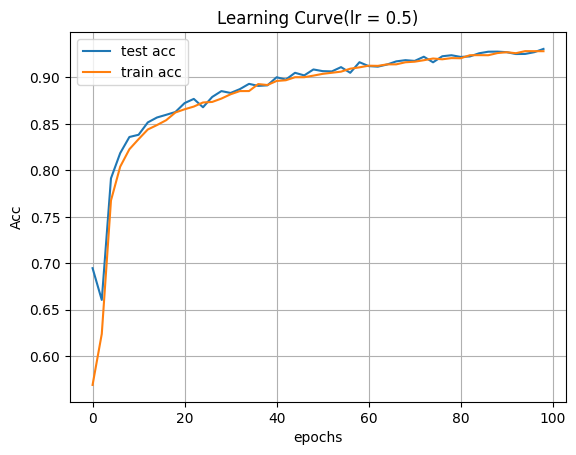

In [64]:
plt.figure(2)
plt.plot(np.arange(0,100,2),acc_list)
plt.plot(np.arange(0,100,2),train_acc_list)
plt.xlabel('epochs')
plt.ylabel('Acc')
plt.grid()
plt.legend(labels=['test acc', 'train acc'])
plt.title("Learning Curve(lr = 0.5)")

In [67]:
class NN3_winit(nn.Module):
    def __init__(self, mode=0):
        super(NN3_winit, self).__init__()
        self.fc1 = nn.Linear(784, 300)
        self.fc2 = nn.Linear(300,200)
        self.fc3 = nn.Linear(200,10)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if(mode == 0):
                    m.weight.data.uniform_(-1,1)
                else:
                    m.weight.data.uniform_(0,0)
                m.bias.data.zero_()

        
    def forward(self, x):
        x = x.view(-1, 784)
        x = f.sigmoid(self.fc1(x))
        x = f.sigmoid(self.fc2(x))
        x = f.softmax(self.fc3(x),dim=0)
        return x

In [68]:
# Q4 (b)
clf = NN3_winit()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(clf.parameters(),lr = 0.5)
epochs = 100
acc_list = []
train_acc_list = []

for epoch in range(0,epochs):
    sum_loss = 0.0
    train_correct = 0
    for data in train_loader:
        inputs, lables = data
        optimizer.zero_grad()
        outputs = clf(inputs)
        loss = criterion(outputs, lables)
        loss.backward()
        optimizer.step()
        _, id = torch.max(outputs.data, 1)
        sum_loss += loss.data
        train_correct += torch.sum(id == lables.data)
    if(epoch%2 == 0):
        clf.eval()
        test_correct = 0
        for data in test_loader:
            inputs, labels = data
            outputs = clf(inputs)
            _, id = torch.max(outputs.data, 1)
            test_correct += torch.sum(id == labels)
        acc_list.append(test_correct/len(test_dataset)) 
        train_acc_list.append(train_correct / len(train_dataset))   
        print("epoch:{} loss: {}, acc:{:.3}".format(epoch, sum_loss, test_correct/len(test_dataset)))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch:0 loss: 3961.87353515625, acc:0.72
epoch:2 loss: 3863.7998046875, acc:0.789
epoch:4 loss: 3852.728271484375, acc:0.817
epoch:6 loss: 3849.48779296875, acc:0.835
epoch:8 loss: 3848.053466796875, acc:0.838
epoch:10 loss: 3845.64990234375, acc:0.842
epoch:12 loss: 3844.180908203125, acc:0.854
epoch:14 loss: 3842.877197265625, acc:0.859
epoch:16 loss: 3843.01318359375, acc:0.862
epoch:18 loss: 3841.800537109375, acc:0.872
epoch:20 loss: 3842.287353515625, acc:0.873
epoch:22 loss: 3840.46240234375, acc:0.881
epoch:24 loss: 3840.146484375, acc:0.883
epoch:26 loss: 3838.303466796875, acc:0.876
epoch:28 loss: 3838.875244140625, acc:0.885
epoch:30 loss: 3838.192138671875, acc:0.887
epoch:32 loss: 3837.458740234375, acc:0.892
epoch:34 loss: 3838.158203125, acc:0.896
epoch:36 loss: 3837.1552734375, acc:0.896
epoch:38 loss: 3836.98046875, acc:0.901
epoch:40 loss: 3837.55078125, acc:0.899
epoch:42 loss: 3836.5205078125, acc:0.895
epoch:44 loss: 3835.488525390625, acc:0.903
epoch:46 loss: 3836

In [69]:
acc_list1 = acc_list
train_acc_list1 = train_acc_list

In [ ]:
# Q4 (b)
clf = NN3_winit(1)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(clf.parameters(),lr = 0.5)
epochs = 100
acc_list = []
train_acc_list = []

for epoch in range(0,epochs):
    sum_loss = 0.0
    train_correct = 0
    for data in train_loader:
        inputs, lables = data
        optimizer.zero_grad()
        outputs = clf(inputs)
        loss = criterion(outputs, lables)
        loss.backward()
        optimizer.step()
        _, id = torch.max(outputs.data, 1)
        sum_loss += loss.data
        train_correct += torch.sum(id == lables.data)
    if(epoch%2 == 0):
        clf.eval()
        test_correct = 0
        for data in test_loader:
            inputs, labels = data
            outputs = clf(inputs)
            _, id = torch.max(outputs.data, 1)
            test_correct += torch.sum(id == labels)
        acc_list.append(test_correct/len(test_dataset)) 
        train_acc_list.append(train_correct / len(train_dataset))   
        print("epoch:{} loss: {}, acc:{:.3}".format(epoch, sum_loss, test_correct/len(test_dataset)))

Text(0.5, 1.0, 'Learning Curve(lr = 0.5)')

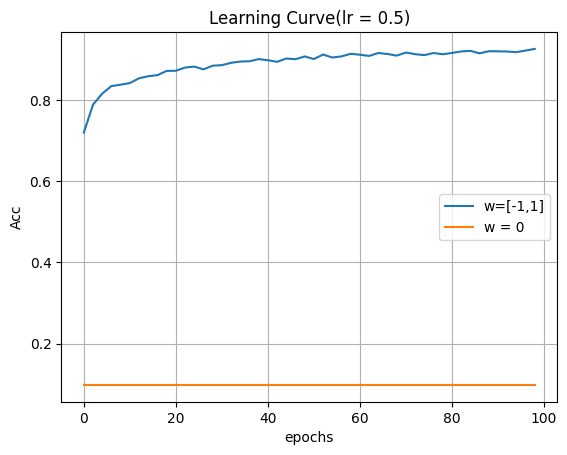

In [71]:
plt.figure(3)
plt.plot(np.arange(0,100,2),acc_list1)
plt.plot(np.arange(0,100,2),np.ones(50)*0.098)
plt.xlabel('epochs')
plt.ylabel('Acc')
plt.grid()
plt.legend(labels=['w=[-1,1]', 'w = 0'])
plt.title("Learning Curve(lr = 0.5)")